# Importing Required Modules

In [7]:
import os, sys
rmg_path = os.getenv('RMGpy')
# if rmg_path does not have anything, and it is not in sys path, add it to sys path
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)  #? 1? Help if looking for multiple?
import os
import re
import numpy as np
from collections import defaultdict, OrderedDict
import pandas as pd
from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
import itertools
import IPython
from IPython.display import display, Markdown
# investigate
def mprint(s): display(Markdown(s))

## Function for Determing if Species is Reactant or Product

In [8]:
def isReactantOrProduct(self, reactant):
        """
        Checks to see if a certiant rmgpy.molecule object is in 
        either the reactants side or products side of rmgpy.reaction
        
        Inputs: 
        self (rmgpy.reaction)
        reactant (rmgpy.molecule)
        
        Output:
        result (bool) - True if reactant is in the reaction, Fasle if not.
        """
        
        if reactant in self.reactants:
            gotOne = True
        elif reactant in self.products:
            gotOne = True
        else: 
            gotOne = False
        return gotOne
    
#self = df.iloc[0,1]
#reactant = Molecule(SMILES="OO")
#isReactantOrProduct(self, reactant)

# Original Code, does not look at QM files directly

In [17]:
#TODO make changes to this like we did with the updated ones (Nate helped), this is vague because I don't know what to call it
directory = '/gss_gpfs_scratch/harms.n/comparerTST'
results = defaultdict(OrderedDict)
# seems like two data types

# list of all log files
comparerFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

#iterating over the list to count them
k = 0
for fil in comparerFiles:
    if ".log" in fil: # and "updated" in fil: # ask about including 'updated'
        k += 1
results = defaultdict(OrderedDict)

#place to store reactions that are not OOH abstractions
not_ooh_abstraction = []

# most important checkpoints
successKey = 'Normal termination of Gaussian'
failKey = "Error termination"

# for 'index of log file' in range 'all log files'
for i in range(1,k+1):
    r = results[i]
    
    #' {0:d}  '.format( ) ensures placement of integer
    filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i) 
    filepath = os.path.join(directory,filename)
    
    # reversing and making sure log file exists
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    else:
        continue
    
    # using with to open file, read contents, then close file
    with open(filepath) as f:
        lines = f.readlines()
    
    # j is iterator, while l is the line - enumerate splits these up
    for j,l in enumerate(lines):
        # set m to whatever is at the end of the line (reaction)
        #m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
        
        # if it 'performCalcs INFO reaction'
        if re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l):
            m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
            # "first parenthesized sub-group"
            rxn = eval(m.group(1))
            
            # checking it is OOH abstraction
            if not (isReactantOrProduct(rxn, Molecule(SMILES="[O]O")) and isReactantOrProduct(rxn, Molecule(SMILES="OO"))): #Checking to make sure that 
                not_ooh_abstraction.append(i) 
                break
            
            r['0 reaction'] = rxn

#TODO erase after checking the above works      
'''    for j,l in enumerate(lines):
        m = re.match('comparerTST.py:177 performCalcs INFO reaction: (.*)', l)
        
        # if it 'performCalcs INFO reaction'
        if m:
            # "first parenthesized sub-group"
            rxn = eval(m.group(1))
            
            # checking it is OOH abstraction
            if not (isReactantOrProduct(rxn, Molecule(SMILES="[O]O")) and isReactantOrProduct(rxn, Molecule(SMILES="OO"))): #Checking to make sure that 
                not_ooh_abstraction.append(i) 
                break
            r['0 reaction'] = rxn      
 '''      

        # adding 'checkpoints to r dict if they exist, changing around checkpoint name too'
        if 'We have generated a H_Abstraction reaction that matches, and used it to label the atoms' in l:
            r['2 matched H-abstraction'] = 1
          
        if 'Reading existing kinetics file' in l:
            r['XX using existing kinetics data file'] = 1 # Reading in existing .kinetics file
             
        if 'Generating a TS geometry via the direct guess method' in l:
            r['3A started making TS geometry'] = 1
        if "Reading existing ts file" in l:
            r['3B using existing TS data file'] = 1 # If reading in existing .ts file, this bypasses 4, 5 and 6
        
        #3C
        if 'optimizeTS INFO Output file' and 'exists and looks complete. Trying that.' in l:
            r['3C Previous TS optimization complete'] = 1 #If reading in existing .log, this then checks if there is an existing IRC calc   
        
        if 'Running loose optimization of TS with frozen center' in l:
            r['4A TS opt w frozen center'] = 1    
        if 'Optimization of TS reaction center distances' in l:
            r['4B TS opt of rxn center'] = 1  
        if 'Optimizing TS attempt' in l:
            r['4C TS optimization started'] = 1
        
        #5A
        # 'verifying...' prints whenever the file is being verified
        # do you want 5A=1 if TS is complete but does not have all the keywords for success?
        if 'verifyOutputFile INFO Verifying output file' in l:
            r['5A New TS optimization complete'] = 1
        #    
        
        if 'Creating IRC file' in l:
            r['6A IRC file created'] = 1
        if "Verifying the IRC output file" in l:
            r['6B New IRC calc complete'] = 1
        if "saveTSData INFO Saving TS result file" in l:
            r['6C New IRC calc successful'] = 1   
            
        if 'Symmetry input file written to' in l:
            r['7A starting Symmetry calculation'] = 1
        if 'Point group:' in l:
            r['7B Symmetry calc successful'] = 1
         
        if 'CanTherm execution initiated' in l:
            r['8 CanTherm started'] = 1
        if 'One or both of the barrier heights of' in l:
            r['8A CanTherm barrier height problem'] = -1
         
        if 'Yay, reaction kinetics calculated!!!' in l:
            r['ZZ overall success'] = 1
            r['ZZZ Complete'] = 1
            
        if "Boo," in l:
            r['ZZ overall fail'] = 1
            r['ZZZ Complete'] = 1
        
        if "gaussian.py:880 verifyIRCOutputFile ERROR Not all of the required keywords for success were found in the IRC output file!" in l:
            r['ZZZ IRC success keywords not found'] = 1

    # 'checkpoints' that require multiple other checkpoints
    if 'XX using existing TS data file' and 'ZZ overall success' in r.keys():
        r['YY successful prior calculation'] = 1
        
    if '5A New TS optimization complete' and '6A IRC file created' in r.keys():
        r['5B TS successfully optimized'] = 1
    
    if '6B New IRC calc complete' in r.keys() and "6A IRC file created" not in r.keys():
        r['6D IRC calc from previous calculation'] = 1
        del(r['6B New IRC calc complete'])
        
    if '5A New TS optimization complete' and '5C Previous TS optimization complete' in r.keys():
        del(r['5A New TS optimization complete'])
    
    """
    if '3C Previous TS optimization complete' in r.keys():
            
        qmScratchDir = '/gss_gpfs_scratch/harms.n/QMscratch/'

        fileNames = [f for f in os.listdir(qmScratchDir) if os.path.isfile(os.path.join(qmScratchDir, f))]

        r1, r2 = eval(rxn).reactants
        p1, p2 = eval(rxn).products
        

        r1SMILES = r1.toSMILES()
        
        r2SMILES = r2.toSMILES()
        p1SMILES = p1.toSMILES()
        p2SMILES = p2.toSMILES()
        
        r1Augmented = r1.toInChIKey()
        r2Augmented = r2.toInChIKey()
        p1Augmented = p1.toInChIKey()
        p2Augmented = p2.toInChIKey()
        
        for fileName in fileNames:
            if r1Augmented or r2Augmented or p1Augmented or p2Augmented in fileName:
                reactOrProdFilePath = os.path.join(qmScratchDir, fileName)
                f = open(reactOrProdFilePath, "r")
                lastLines = f.readlines()
                    
                if sucessKey or failKey in lastLines:
                    r['WW.0 Complete Reactants / Products Estimate'] = 1
                if failKey in lastLines:
                    r['WW.1 Fail Reactants / Products Estimate'] = 1 
                
            if r1SMILES and r2SMILES and p1SMILES and p2SMILES and ".log" in fileName:
                if "Est" in fileName:
                    est = os.path.join(qmScratchDir, fileName)
                    f = open(est, "r")
                    lastLines = f.readlines()
                    #f.closed
                    
                    if sucessKey or failKey in lastLines:
                        r['WW.A Complete TS Estimate'] = 1
                    if sucessKey in lastLines:
                        r['WW.B Successful TS Estimate'] = 1
                             
                    # check complete
                elif "RxnC" in fileName:
                    rxnC = os.path.join(qmScratchDir, fileName)
                    f = open(rxnC, "r")
                    lastLines = f.readlines()
                    #f.closed()
                    
                    if sucessKey or failKey in lastLines:
                        r['WW.C Complete Rxn Center'] = 1
                    if sucessKey in lastLines:
                        r['WW.D Successful Rxn Center'] = 1
                    # check complete
                    
                elif "IRC" in fileName:
                    IRC = os.path.join(qmScratchDir, fileName)
                    f = open(IRC, "r")
                    lastLines = f.readlines()
                    #f.closed()
                    
                    if sucessKey or failKey in lastLines:
                        r['WW.G Complete IRC log'] = 1
                    if sucessKey in lastLines:
                        r['WW.H Successful IRC log'] = 1
                    # check complete
                    
                else:
                    overall = os.path.join(qmScratchDir, fileName)
                    f = open(overall, "r")
                    lastLines = f.readlines()[-4:]
                    #f.closed()
                    
                    if sucessKey or failKey in lastLines:
                        r['WW.E Complete overall TS log'] = 1
                    if sucessKey in lastLines:
                        r['WW.F Successful overall TS log'] = 1
                    # check complete
                    """
                    
                    

               
# remobing non OOH absraction reactions
for i in not_ooh_abstraction:
    del(results[i])

# creating pandas data frame (keys as row titles)
dfold = pd.DataFrame(results)

#printing DF
dfold

,1,2,3,4,5,6,7,8,9,10,...,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046
1 log file exists,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 matched H-abstraction,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3A started making TS geometry,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3B using existing TS data file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3C Previous TS optimization complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4A TS opt w frozen center,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4B TS opt of rxn center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C TS optimization started,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5A New TS optimization complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5B TS successfully optimized,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dfold.count(axis=1)

1 log file exists                        999
2 matched H-abstraction                  998
3A started making TS geometry            700
3B using existing TS data file            51
3C Previous TS optimization complete     209
4A TS opt w frozen center                437
4B TS opt of rxn center                  430
4C TS optimization started               428
5A New TS optimization complete          635
5B TS successfully optimized             391
6A IRC file created                      391
6B New IRC calc complete                 391
6C New IRC calc successful               319
6D IRC calc from previous calculation    110
7A starting Symmetry calculation         361
7B Symmetry calc successful              211
8 CanTherm started                       207
8A CanTherm barrier height problem        37
XX using existing kinetics data file     298
YY successful prior calculation          463
ZZ overall fail                          355
ZZ overall success                       463
ZZZ Comple

## QM File Succeskey/Failkey Search Functions

In [9]:
def checkSpeciesFile(filename, sucComp):
    allSuccesful, allComplete = sucComp
    
    reactOrProdFilePath = os.path.join(qmScratchDir, fileName)
    f = open(reactOrProdFilePath, "r")

    lines = f.readlines()
    # because each reaction needs multiple reactants/products to be checked,
    # this becomes more complicated
    
    foundKey = False
    
    for line in lines:
        if failKey in line:
            allSuccesful = False
            foundKey = True
            r['WW.2 ATLEAST ONE Fail Reactants / Products Estimate'] = 1
        elif successKey in line:
            foundKey = True
            r['WW.3 ATLEAST ONE Succesful Reactants / Products Estimate'] = 1

    if foundKey:
        r['WW.0 ATLEAST ONE Complete Reactants / Products Estimate'] = 1
    else:
        r['WW.1 ATLEAST ONE Incomplete Reactants / Products Estimate'] = 1
        allComplete = False
    
    sucComp = allSuccesful, allComplete
    return sucComp


def checkReactionFile(filename):        
    # shell of reaction
    if "Est" in fileName:
        est = os.path.join(qmScratchDir, fileName)
        f = open(est, "r")
        lines = f.readlines()

        for line in lines:
            if successKey or failKey in line:
                r['WW.A Complete TS Estimate'] = 1
            if successKey in line:
                r['WW.B Successful TS Estimate'] = 1
            
    # Reaction Center
    elif "RxnC" in fileName:
        rxnC = os.path.join(qmScratchDir, fileName)
        f = open(rxnC, "r")
        lines = f.readlines()
  
        for line in lines:
            if successKey or failKey in line:
                r['WW.C Complete Rxn Center'] = 1
            if successKey in line:
                r['WW.D Successful Rxn Center'] = 1
            
    #walking down slope
    elif "IRC" in fileName:
        IRC = os.path.join(qmScratchDir, fileName)
        f = open(IRC, "r")
        lines = f.readlines()

        for line in lines:
            if successKey or failKey in line:
                r['WW.G Complete IRC log'] = 1
            if successKey in line:
                r['WW.H Successful IRC log'] = 1


    else:
        overall = os.path.join(qmScratchDir, fileName)
        f = open(overall, "r")
        lines = f.readlines()[-4:]
        
        for line in lines:
            if successKey or failKey in line:
                r['WW.E Complete overall TS log'] = 1
            else:
                ThreeCStatus = False;
                
            if successKey in line:
                r['WW.F Successful overall TS log'] = 1

    return ThreeCStatus
print 'done'

done


## Function for generating portion of Reaction Kinetics File Name

In [10]:
# TODO make into list of products and reactants
def possibleNames(r1SMILES, r2SMILES, p1SMILES, p2SMILES):
    reactants = (r1SMILES, r2SMILES)
    products = (p1SMILES, p2SMILES)

    joinedReactOrders = []
    joinedProdOrders = []
# TODO check list comprehension method

    joinedReactOrders = ['+'.join(order) for order in itertools.permutations(reactants)]
#    for order in itertools.permutations(reactants):
#        joinedReactOrders.append('+'.join(order))

#    for order in itertools.permutations(products):
#        joinedProdOrders.append('+'.join(order))
    joinedProdOrders = ['+'.join(order) for order in itertools.permutations(products)]

    fileNames = ['_'.join((rJO, pJO)) for rJO in joinedReactOrders for pJO in joinedProdOrders]

    return fileNames
print 'done'

done


# Updated Main Code

In [20]:
directory = '/gss_gpfs_scratch/harms.n/comparerTST'
results = defaultdict(OrderedDict)
# seems like two data types

# list of all log files
comparerFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

#iterating over the list to count them
"""k = 0
for fil in comparerFiles:
    if ".log" in fil: # and "updated" in fil: # ask about including 'updated'
        k += 1"""
results = defaultdict(OrderedDict)

#place to store reactions that are not OOH abstractions
not_ooh_abstraction = []

# what do you seek?
successKey = 'Normal termination of Gaussian'
failKey = "Error termination"

# for 'index of log file' in range 'all log files'
for i in range(1,1050):
    r = results[i]
    
    #' {0:d}  '.format( ) ensures placement of integer
    if i < 1000:
        filename = 'AutoTST-comparer.updated.{0:d}.combined.log'.format(i)
        filepath = os.path.join(directory,filename)
    elif i < 1050:
        i_new = i - 999
        filename = 'AutoTST-comparer.updated.1.{0:d}.combined.log'.format(i_new)
        filepath = os.path.join(directory,filename)
    
    # reversing and making sure log file exists
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    else:
        continue
    
    # using with to open file, read contents, then close file
    with open(filepath) as f:
        lines = f.readlines()
    
    # j is iterator, while l is the line - enumerate splits these up
    for j,l in enumerate(lines):
        # set m to whatever is at the end of the line (reaction)
        #m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
        
        # if it 'performCalcs INFO reaction'
        if re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l):
            m = re.match('comparerTST.py:14[1-9] performCalcs INFO chemkinRxn: (.*)', l)
            # "first parenthesized sub-group"
            rxn = eval(m.group(1))
            
            # checking it is OOH abstraction
            if not (isReactantOrProduct(rxn, Molecule(SMILES="[O]O")) and isReactantOrProduct(rxn, Molecule(SMILES="OO"))): #Checking to make sure that 
                not_ooh_abstraction.append(i) 
                break
            
            r['0 reaction'] = rxn
        
            
        # adding 'checkpoints to r dict if they exist, changing around checkpoint name too'
        if 'We have generated a H_Abstraction reaction that matches, and used it to label the atoms' in l:
            r['2 matched H-abstraction'] = 1
          
        if 'Reading existing kinetics file' in l:
            r['XX using existing kinetics data file'] = 1 # Reading in existing .kinetics file
             
        if 'Generating a TS geometry via the direct guess method' in l:
            r['3A started making TS geometry'] = 1
        if "Reading existing ts file" in l:
            r['3B using existing ts data file'] = 1 # If reading in existing .ts file, this bypasses 4, 5 and 6
        
        #3C
        if 'optimizeTS INFO Output file' and 'exists and looks complete. Trying that.' in l:
            r['3C Previous TS optimization complete'] = 1 #If reading in existing .log, this then checks if there is an existing IRC calc   
            
            qmScratchDir = '/gss_gpfs_scratch/harms.n/QMscratch'

            fileNames = [f for f in os.listdir(qmScratchDir) if os.path.isfile(os.path.join(qmScratchDir, f))]

            r1, r2 = rxn.reactants
            p1, p2 = rxn.products

            # TODO check list of products and reactants
            r1SMILES = r1.toSMILES()
            r2SMILES = r2.toSMILES()
            rxnReactants = r1, r2

            p1SMILES = p1.toSMILES()
            p2SMILES = p2.toSMILES()
            rxnProducts = p1, p2

            r1Augmented = r1.toInChIKey()
            r2Augmented = r2.toInChIKey()
            p1Augmented = p1.toInChIKey()
            p2Augmented = p2.toInChIKey()

            #TODO rename to species or reaction instead of auginchi or smile
            allAugInchis = (r1Augmented, r2Augmented, p1Augmented, p2Augmented)

            #smileFileNames = []
            #augFileNames = {}

            allSuccesful = True
            allComplete = True
            sucComp = allSuccesful, allComplete

            for fileName in fileNames:

                for possibleName in possibleNames(r1SMILES, r2SMILES, p1SMILES, p2SMILES):

                    if possibleName in fileName and '.log' in fileName:
                        checkReactionFile(fileName)
                        #smileFileNames.append(fileName)

                for augInchi in allAugInchis:

                    if augInchi in fileName and '.log' in fileName:
                        allSuccesful, allComplete = checkSpeciesFile(fileName, sucComp)
                        #augFileNames[augInchi] = fileName

            if allComplete:
                r['WW.4 ALL Complete Reactants / Products Estimate'] = 1
                
                if 'WW.A Complete TS Estimate' and 'WW.C Complete Rxn Center' and 'WW.G Complete IRC log' and 'WW.E Complete overall TS log' in r.keys():
                    r['WW.Z 3C has been verified'] = 1
    

                
            if allSuccesful and allComplete:
                r['WW.5 ALL Successful Reactants / Products Estimate'] = 1
        
        if 'Running loose optimization of TS with frozen center' in l:
            r['4A TS opt w frozen center'] = 1    
        if 'Optimization of TS reaction center distances' in l:
            r['4B TS opt of rxn center'] = 1  
        if 'Optimizing TS attempt' in l:
            r['4C TS optimization started'] = 1
        
        #5A
        # 'verifying...' prints whenever the file is being verified
        # do you want 5A=1 if TS is complete but does not have all the keywords for success?
        if 'verifyOutputFile INFO Verifying output file' in l:
            r['5A New TS optimization complete'] = 1
        #    
        
        if 'Creating IRC file' in l:
            r['6A IRC file created'] = 1
        if "Verifying the IRC output file" in l:
            r['6B New IRC calc complete'] = 1
        if "saveTSData INFO Saving TS result file" in l:
            r['6C New IRC calc successful'] = 1   
            
        if 'Symmetry input file written to' in l:
            r['7A starting Symmetry calculation'] = 1
        if 'Point group:' in l:
            r['7B Symmetry calc successful'] = 1
         
        if 'CanTherm execution initiated' in l:
            r['8 CanTherm started'] = 1
        if 'One or both of the barrier heights of' in l:
            r['8A CanTherm barrier height problem'] = -1
         
        if 'Yay, reaction kinetics calculated!!!' in l:
            r['ZZ overall success'] = 1
            r['ZZZ Complete'] = 1
            
        if "Boo," in l:
            r['ZZ overall fail'] = 1
            r['ZZZ Complete'] = 1
        
        if "gaussian.py:880 verifyIRCOutputFile ERROR Not all of the required keywords for success were found in the IRC output file!" in l:
            r['ZZZ IRC success keywords not found'] = 1

    # 'checkpoints' that require multiple other checkpoints
    if 'XX using existing TS data file' and 'ZZ overall success' in r.keys():
        r['YY successful prior calculation'] = 1
        
    if '5A New TS optimization complete' and '6A IRC file created' in r.keys():
        r['5B TS successfully optimized'] = 1
    
    if '6B New IRC calc complete' in r.keys() and "6A IRC file created" not in r.keys():
        r['6D IRC calc from previous calculation'] = 1
        del(r['6B New IRC calc complete'])
        
    if '5A New TS optimization complete' and '5C Previous TS optimization complete' in r.keys():
        del(r['5A New TS optimization complete'])
    
    
    
# removing non OOH absraction reactions
for i in not_ooh_abstraction:
    del(results[i])

# creating pandas data frame (keys as row titles)
df = pd.DataFrame(results)

#printing DF
df

,1,2,3,4,5,6,7,8,9,10,...,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049
0 reaction,"<Molecule ""[O]O""> + <Molecule ""C1=CC=CC(C=1)C1...","<Molecule ""CCCCCC1CCCCO1""> + <Molecule ""[O]O"">...","<Molecule ""CCCCCCCCCC=O""> + <Molecule ""[O]O""> ...","<Molecule ""CCCCCCC1CCCO1""> + <Molecule ""[O]O"">...","<Molecule ""CCCCCCCC1CCO1""> + <Molecule ""[O]O"">...","<Molecule ""CCCCCCCCCCC""> + <Molecule ""[O]O""> <...","<Molecule ""CCCCCCCCCCC""> + <Molecule ""[O]O""> <...","<Molecule ""CCCCCCCCCCC""> + <Molecule ""[O]O""> <...","<Molecule ""CCCCCCCCCCC""> + <Molecule ""[O]O""> <...","<Molecule ""CCCCCCCCCCC""> + <Molecule ""[O]O""> <...",...,"<Molecule ""CCCCCCC(CCCCC)O[O]""> + <Molecule ""O...","<Molecule ""CCCCCCCCCC(CC)O[O]""> + <Molecule ""O...","<Molecule ""CCCCCCCCC(CCC)O[O]""> + <Molecule ""O...","<Molecule ""CCCCCCCC(CCCC)O[O]""> + <Molecule ""O...","<Molecule ""CCCCCCCCCCC(C)O[O]""> + <Molecule ""O...","<Molecule ""CCCCCCCCCCCCO[O]""> + <Molecule ""OO""...","<Molecule ""[O]OC(CC1C=CC=CC=1)C1C=CC=CC=1""> + ...",NaN,NaN,NaN
1 log file exists,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.0,NaN,NaN
2 matched H-abstraction,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,NaN,NaN,NaN
3A started making TS geometry,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,NaN,NaN,NaN
3B using existing ts data file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3C Previous TS optimization complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4A TS opt w frozen center,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,NaN,NaN,NaN
4B TS opt of rxn center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C TS optimization started,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5A New TS optimization complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Frame Summary

In [21]:
df.count(axis=1)

0 reaction                                                  1044
1 log file exists                                           1046
2 matched H-abstraction                                     1044
3A started making TS geometry                                738
3B using existing ts data file                                51
3C Previous TS optimization complete                         216
4A TS opt w frozen center                                    468
4B TS opt of rxn center                                      439
4C TS optimization started                                   437
5A New TS optimization complete                              651
5B TS successfully optimized                                 398
6A IRC file created                                          398
6B New IRC calc complete                                     396
6C New IRC calc successful                                   323
6D IRC calc from previous calculation                        110
7A starting Symmetry calc

# Test Case

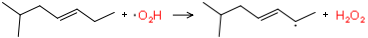

In [11]:
# Test cases
r1 = Molecule(SMILES="CCC=CCC(C)C")
r2 = Molecule(SMILES="[O]O")
p1 = Molecule(SMILES="C[CH]C=CCC(C)C")
p2 = Molecule(SMILES="OO")
rxn = Reaction(reactants=[r1, r2], products=[p1, p2], reversible=True)
rxn

### Code for Test Case

In [13]:
successKey = 'Normal termination of Gaussian' #, '******    1 imaginary frequencies (negative Signs) ******',]

failKey = 'Error termination' #, 'Error in internal coordinate system.',]

r = {}

qmScratchDir = '/gss_gpfs_scratch/harms.n/QMscratch'

fileNames = [f for f in os.listdir(qmScratchDir) if os.path.isfile(os.path.join(qmScratchDir, f))]

r1, r2 = rxn.reactants
p1, p2 = rxn.products

r1SMILES = r1.toSMILES()
r2SMILES = r2.toSMILES()
rxnReactants = r1, r2

p1SMILES = p1.toSMILES()
p2SMILES = p2.toSMILES()
rxnProducts = p1, p2

allSmiles = (r1SMILES, r2SMILES, p1SMILES, p2SMILES)

r1Augmented = r1.toInChIKey()
r2Augmented = r2.toInChIKey()
p1Augmented = p1.toInChIKey()
p2Augmented = p2.toInChIKey()

allAugInchis = (r1Augmented, r2Augmented, p1Augmented, p2Augmented)

smileFileNames = []
augFileNames = {}

allSuccesful = True
allComplete = True
sucComp = allSuccesful, allComplete

for fileName in fileNames:

#maybe change to list comprehension method? - It looks henious when done
    for possibleName in possibleNames(r1SMILES, r2SMILES, p1SMILES, p2SMILES):

        if possibleName in fileName and '.log' in fileName:
            checkReactionFile(fileName)
            smileFileNames.append(fileName)

    for augInchi in allAugInchis:

        if augInchi in fileName and '.log' in fileName:
            allSuccesful, allComplete = checkSpeciesFile(fileName, sucComp)
            augFileNames[augInchi] = fileName
# TODO update WW numbering in UPDATED MAIN CODE
if allComplete:
    r['WW.4 ALL Complete Reactants / Products Estimate'] = 1    
if allSuccesful and allComplete:
    r['WW.5 ALL Successful Reactants / Products Estimate'] = 1

print
print allSmiles
print
print possibleNames(r1SMILES, r2SMILES, p1SMILES, p2SMILES)
print
print smileFileNames
print
print allAugInchis
print 
print augFileNames
print
r


('CCC=CCC(C)C', '[O]O', 'C[CH]C=CCC(C)C', 'OO')

['CCC=CCC(C)C+[O]O_C[CH]C=CCC(C)C+OO', 'CCC=CCC(C)C+[O]O_OO+C[CH]C=CCC(C)C', '[O]O+CCC=CCC(C)C_C[CH]C=CCC(C)C+OO', '[O]O+CCC=CCC(C)C_OO+C[CH]C=CCC(C)C']

['CCC=CCC(C)C+[O]O_C[CH]C=CCC(C)C+OO.log', 'CCC=CCC(C)C+[O]O_C[CH]C=CCC(C)C+OORxnC.log', 'CCC=CCC(C)C+[O]O_C[CH]C=CCC(C)C+OO.log.TS1.log', 'CCC=CCC(C)C+[O]O_C[CH]C=CCC(C)C+OOIRC.log', 'CCC=CCC(C)C+[O]O_C[CH]C=CCC(C)C+OOEst.log']

('PMPISKBGRHSPEE-UHFFFAOYSA', 'OUUQCZGPVNCOIJ-UHFFFAOYSA', 'IYRDAWFXJBSJBT-UHFFFAOYSA', 'MHAJPDPJQMAIIY-UHFFFAOYSA')

{'IYRDAWFXJBSJBT-UHFFFAOYSA': 'IYRDAWFXJBSJBT-UHFFFAOYSA-u4.log', 'PMPISKBGRHSPEE-UHFFFAOYSA': 'PMPISKBGRHSPEE-UHFFFAOYSA.log', 'MHAJPDPJQMAIIY-UHFFFAOYSA': 'MHAJPDPJQMAIIY-UHFFFAOYSA.log', 'OUUQCZGPVNCOIJ-UHFFFAOYSA': 'OUUQCZGPVNCOIJ-UHFFFAOYSA-u2.log'}



{'WW.0 ATLEAST ONE Complete Reactants / Products Estimate': 1,
 'WW.3 ATLEAST ONE Succesful Reactants / Products Estimate': 1,
 'WW.4 ALL Complete Reactants / Products Estimate': 1,
 'WW.5 ALL Successful Reactants / Products Estimate': 1,
 'WW.A Complete TS Estimate': 1,
 'WW.C Complete Rxn Center': 1,
 'WW.D Successful Rxn Center': 1,
 'WW.E Complete overall TS log': 1,
 'WW.F Successful overall TS log': 1,
 'WW.G Complete IRC log': 1,
 'WW.H Successful IRC log': 1}

### Checking if Two Files are the Same

In [ ]:
# checking to see if these files are the same. If so, why the TS#?
log0 = os.path.join('/gss_gpfs_scratch/harms.n/QMscratch', 'C+[O]O_OO+[CH3].log')

log1 = os.path.join('/gss_gpfs_scratch/harms.n/QMscratch', 'C+[O]O_OO+[CH3].log.TS1.log')

with open(log0, "r") as f:
    lines0 = f.readlines()
    
with open(log1, 'r') as q:
    lines1 = q.readlines()
    
for line0 in lines0:
    if line0 in lines1:
        gotOne=True
    else:
        print("These files are not the same")
        gotOne=False
        break
        
for line1 in lines1:
    if line1 in lines0:
        gotOne=True
    else:
        print("These files are not the same.")
        gotOne=False
        
gotOne